# Heart Rate Monitor

# Biomedical Devices

# Assignment-2

# Sept-Dec 2021

## 1. Stress ECG

## Method 1
## Algorithm implemented : Pan Tompkins Algorithm (using a Band Pass Filter)

In [1]:
from matplotlib import pyplot as plt
from scipy import signal
from matplotlib import style
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter, firwin, convolve


In [2]:
ecg1 = pd.read_csv('MITBIHSTChangeDatabase.csv')
ecg1 = ecg1.drop([0],axis =0)
ecg1.columns = ['Idx', 'ECG']
ecg1['ECG'] = pd.to_numeric(ecg1['ECG'])
ecg1 = ecg1.drop(['Idx'], axis = 1)


### The stress signal is imported and passed through a low pass filter with the following parameters:
1. Number of taps = 51 (a random value)
2. Cutoff = Taken from the signal
3. nyquist rate = 0.5*sampling rate
#### As we can see in the following plots the signal has been smoothened or the noise has been reduced comparably

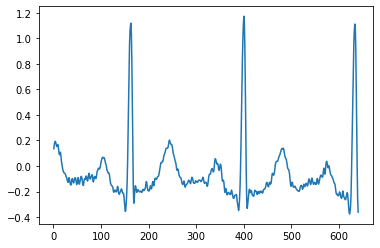

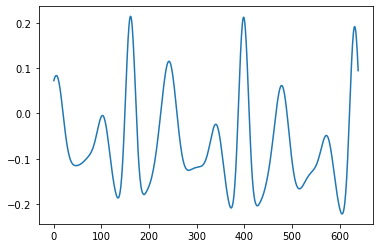

In [3]:
combo_sig = list(ecg1['ECG'][:])
fs = 360
numtaps = 51
lpf_cutoff = 5
plt.figure(1)
plt.plot(ecg1['ECG'][0:640])
#lowpass
lowpass_coeff = firwin(numtaps, lpf_cutoff, nyq = fs/2)
lpf_output = convolve(combo_sig,lowpass_coeff, mode = 'same')
plt.figure(2)
plt.plot(lpf_output[0:640])

## Implementation of Pan Tompkins Algorithm
1. The Band pass filter in the range 5-11Hz has been implemented using a butterworth filter
2. The derivative of the signal is computed next to find the sudden changes in amplitude showing the various waves P,Q,R,S,T
3. Convolution of the filtered signal with a moving window is performed to result in an integrated output
4. Finally the peaks are detected using Janko Slavic peak detection algorithm and implementation
5. We use the indices output from the findpeaks function to be plotted to see the R Peaks
6. As counted from the signal 12 peaks have not been marked and also there have been no noisy peaks evaluated, hence %missing peaks have been calculated
7. Some  of the parameters defined are as follows:

    a. fl - low cut off of band pass filter
    
    b. fh - high cut off of band pass filter
    
    c. fs -  sampling rate of signal
    
    d. int_win - the window size for running integration
    
    e. peak_limit - after observing the integrated window output this was decided upon to identify the peaks
    
    f. peak spacing - the value for the peak duration
    
    g. refractory duration - minimum time between two successive peaks

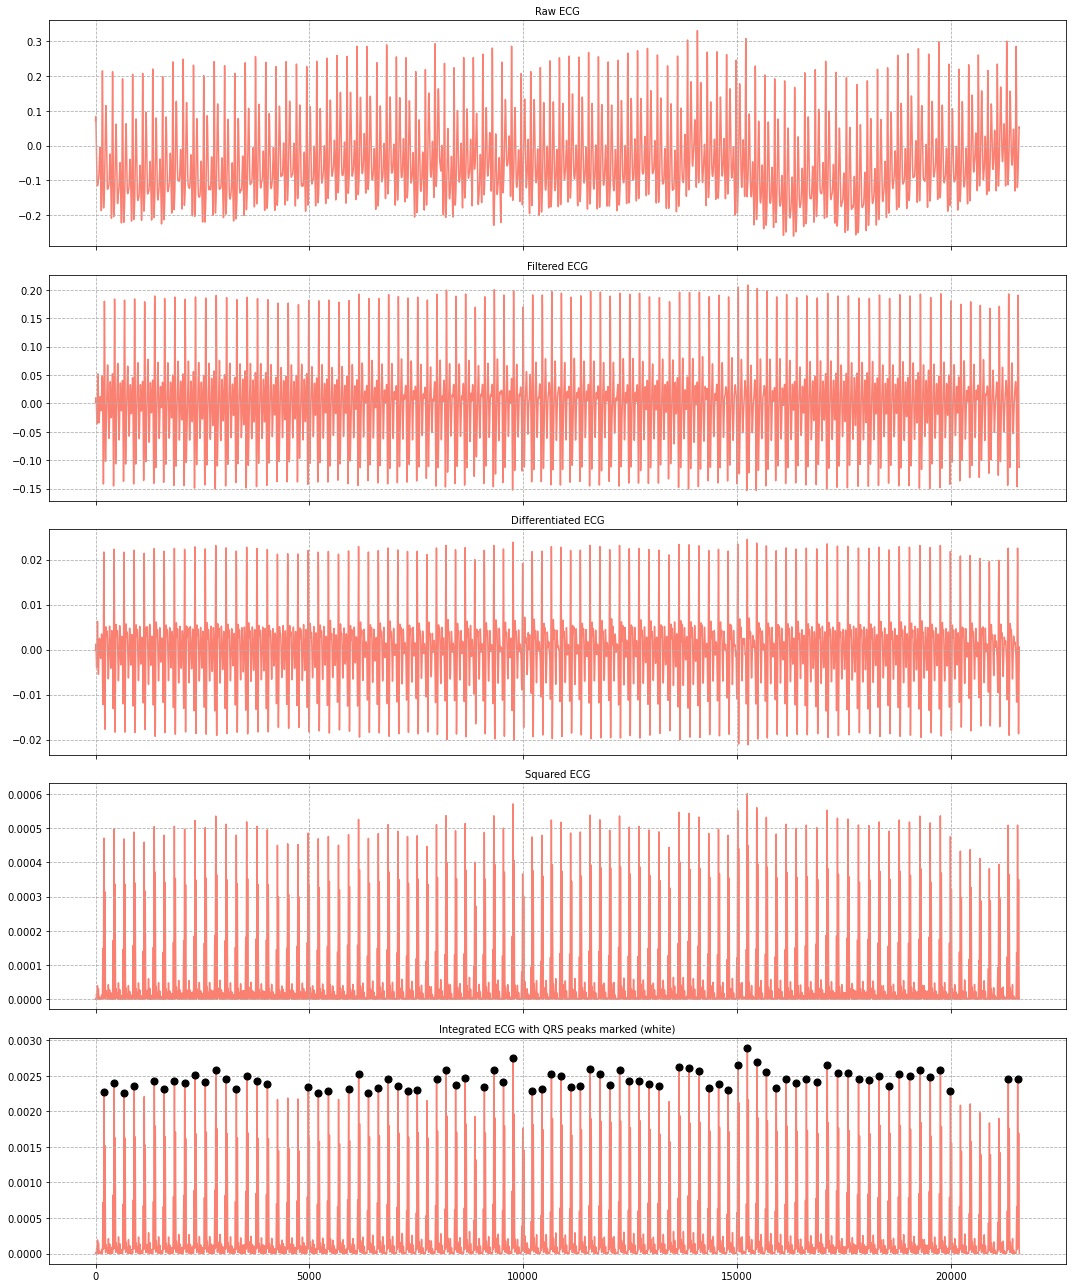

qrs peaks indices
[  198   435   668   905  1374  1606  1845  2085  2328  2567  2813  3055
  3293  3536  3778  4019  4975  5210  5446  5918  6152  6382  6614  6844
  7071  7296  7523  7974  8195  8419  8644  9092  9315  9539  9765 10212
 10437 10660 10883 11110 11337 11566 11795 12024 12254 12482 12709 12941
 13175 13645 13879 14109 14340 14568 14792 15017 15241 15462 15687 15917
 16149 16384 16621 16866 17109 17349 17594 17840 18083 18320 18557 18794
 19033 19277 19518 19755 19990 21342 21561]
noise peaks indices
[]
%Missing peaks:  13.186813186813184


In [4]:
fl = 5
fh = 11.0
fo = 3

int_win = 5  

peak_limit = 0.00225
peak_spacing = 15 

refractory_duration = 180 

filt_ecg = None
diff_ecg= None
squared_ecg = None
int_ecg = None
detected_peaks_indices = None
detected_peaks_values = None


# Detection results.
qrs_peaks_indices = np.array([], dtype=int)
noise_peaks_indices = np.array([], dtype=int)

def detect_peaks(lpf_output,peak_limit,peak_spacing):

    # Measurements filtering - 0-15 Hz band pass filter.
    filt_ecg = bpf(lpf_output, fl, fh, fs, fo)
    filt_ecg[:5] = filt_ecg[5]

    # Derivative
    diff_ecg = np.ediff1d(filt_ecg)

    # Squaring
    squared_ecg = diff_ecg ** 2
    # Moving-window integration.
    int_ecg = np.convolve(squared_ecg, np.ones(int_win))

    # peak detection on integrated measurements.
    peaks_indices = findpeaks(int_ecg, peak_spacing, peak_limit)

    peaks_values = int_ecg[peaks_indices]
    return filt_ecg, diff_ecg, squared_ecg, int_ecg, peaks_indices, peaks_values

def detect_qrs(lpf_output,peaks_indices,peaks_values,qrs_peaks_indices,noise_peaks_indices):
    qrs_peak_value = 0.0
    noise_peak_value = 0.0
    threshold_value = 0.0
        
    for detected_peak_index, detected_peaks_value in zip(peaks_indices, peaks_values):
        last_qrs_index = 0

        if detected_peak_index - last_qrs_index > refractory_duration or not qrs_peaks_indices.size:
            if detected_peaks_value > threshold_value:
                qrs_peaks_indices = np.append(qrs_peaks_indices, detected_peak_index)
                qrs_peak_value = 0.125 * detected_peaks_value + (1 - 0.125)*qrs_peak_value
            else:
                noise_peaks_indices = np.append(noise_peaks_indices, detected_peak_index)
                noise_peak_value = 0.125 * detected_peaks_value + (1 - 0.125) * noise_peak_value

            threshold_value = noise_peak_value + 0.25 * (qrs_peak_value - noise_peak_value)
    return qrs_peaks_indices, noise_peaks_indices


def plot_detection_data(lpf_output, filt_ecg, diff_ecg, squared_ecg, int_ecg, qrs_peaks_indices):
    def plot_data(axis, data, title='' ):
        axis.set_title(title, fontsize=10)
        axis.grid(which='both', axis='both', linestyle='--')
        axis.plot(data, color="salmon", zorder=1)

    def plot_points(axis, values, indices):
        axis.scatter(x=indices, y=values[indices], c="black", s=50, zorder=2)

    plt.close('all')
    fig, axarr = plt.subplots(5, sharex=True, figsize=(15, 18))

    plot_data(axarr[0], lpf_output, title='Raw ECG')
    plot_data(axarr[1], filt_ecg, title='Filtered ECG')
    plot_data(axarr[2], diff_ecg, title='Differentiated ECG')
    plot_data(axarr[3], squared_ecg, title='Squared ECG')
    plot_data(axarr[4], int_ecg, title='Integrated ECG with QRS peaks marked (white)')
    plot_points(axarr[4], int_ecg, qrs_peaks_indices)
    plt.tight_layout()
    plt.show()
    plt.close()

def bpf( data, fl, fh, fs, fo):
    nyq_freq = 0.5 * fs
    low = fl / nyq_freq
    high = fh / nyq_freq
    b, a = butter(fo, [low, high], btype="band")
    y = lfilter(b, a, data)
    return y

def findpeaks(data, spacing, limit):
    len = data.size
    spacing = int(spacing)
    x = np.zeros(int(len + 2 * spacing))
    x[:spacing] = data[0] - 1.e-6
    x[-spacing:] = data[-1] - 1.e-6
    x[spacing:spacing + len] = data
    peak_ = np.zeros(len)
    peak_[:] = True
    for s in range(spacing):
        start = spacing - s - 1
        h_b = x[start: start + len]  
        start = spacing
        h_c = x[start: start + len]  
        start = spacing + s + 1
        h_a = x[start: start + len]  
        peak_ = np.logical_and(peak_, np.logical_and(h_c > h_b, h_c > h_a))

    ind = np.argwhere(peak_)
    ind = ind.reshape(ind.size)
    if limit is not None:
        ind = ind[data[ind] > limit]
    return ind


lpf_output = lpf_output[0:]
filt_ecg, diff_ecg, squared_ecg, int_ecg, peaks_indices, peaks_values = detect_peaks(lpf_output,peak_limit,peak_spacing)
qrs_peaks_indices, noise_peaks_indices = detect_qrs(lpf_output,peaks_indices,peaks_values,qrs_peaks_indices,noise_peaks_indices)
plot_detection_data(lpf_output, filt_ecg, diff_ecg, squared_ecg, int_ecg,qrs_peaks_indices)

print("qrs peaks indices")
print(qrs_peaks_indices)
print("noise peaks indices")
print(noise_peaks_indices)
l = qrs_peaks_indices.size
print("%Missing peaks: ", (1-l/(l+12))*100)

## Method 2
## Pan Tompkins Algorithm using the actual transfer function equations from the original paper and using the same peak detection algorithm as above

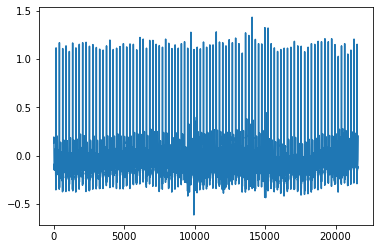

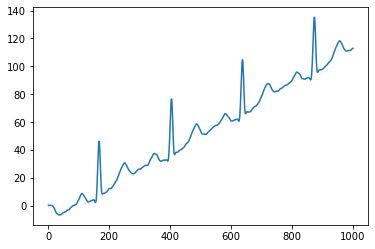

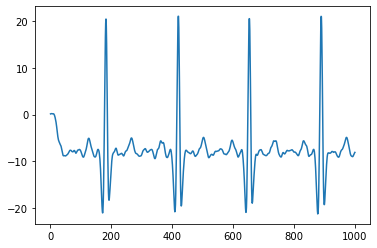

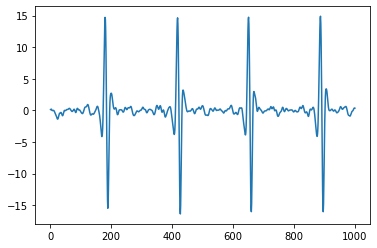

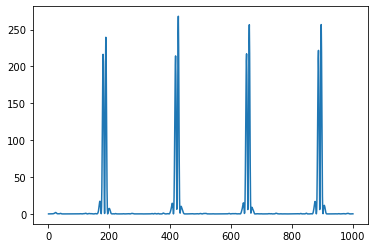

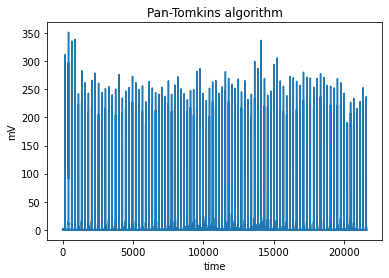

In [5]:
#low-pass filter
def lpf(x):
    y = x.copy()
    for n in range(len(x)):
        if(n < 12):
            continue
        y.iloc[n,1] = 2*y.iloc[n-1,1] - y.iloc[n-2,1] + x.iloc[n,1] - 2*x.iloc[n-6,1] + x.iloc[n-12,1] 
    return y


#high-pass filter
def hpf(x):
    y = x.copy()	
    for n in range(len(x)):        
        if(n < 32):
            continue
        y.iloc[n,1] = y.iloc[n-1,1] - x.iloc[n,1]/32 + x.iloc[n-16,1] - x.iloc[n-17,1] + x.iloc[n-32,1]/32
    return y

#derivative of signal
def deriv(x):
    y = x.copy()
    for n in range(len(x)):
        if(n < 4):
            continue
        y.iloc[n, 1] = (2*x.iloc[n,1] + x.iloc[n-1,1] - x.iloc[n-3,1] - 2*x.iloc[n-4,1])/4
    return y

#squarring the signal
def squaring(x):
    y = x.copy()
    for n in range(len(x)):
        y.iloc[n,1] = x.iloc[n,1]**2
    return y

#integral of the signal for a moving window of ws size.
def win_sum(x, ws):
    y = x.copy()
    l = int(ws/2)	
    for n in range(len(x)):
        tmp_sum = 0
        if(n > 933-l):
            break

        if(n < l):
            continue
        for j in range(n-l,n+l+1):
            tmp_sum += x.iloc[j,1]
        y.iloc[n,1] = tmp_sum/(l+1)		
    return y

ecg1 = pd.read_csv('MITBIHSTChangeDatabase.csv')
ecg1 = ecg1.drop([0],axis =0)
ecg1.columns = ['Idx', 'ECG']
ecg1['ECG'] = pd.to_numeric(ecg1['ECG'])
plt.figure(1)
plt.plot( ecg1.iloc[:,1])

lpf_output = lpf(ecg1)
plt.figure(2)
plt.plot( lpf_output.iloc[:1000,1])

hpf_output = hpf(lpf_output)
plt.figure(3)
plt.plot( hpf_output.iloc[:1000,1])

derivative_output = deriv(hpf_output)
plt.figure(4)
plt.plot(derivative_output.iloc[:1000,1])

squared_output = squaring(derivative_output)
plt.figure(5)
plt.plot(squared_output.iloc[:1000,1])

window_size = 5 
summing_window_output = win_sum(squared_output, window_size)

plt.figure(6)
plt.plot(summing_window_output.iloc[:,1])
plt.title('Pan-Tomkins algorithm')
plt.xlabel('time')
plt.ylabel('mV')
plt.show()


## Normalizing the integrated signal and then from observing we can define a lower limit for the R peak as 0.7 

In [22]:
data = list(summing_window_output['ECG'])/np.max(list(summing_window_output['ECG']))
def findpeaks(data, spacing, limit):
    len = data.size
    spacing = int(spacing)
    x = np.zeros(int(len + 2 * spacing))
    x[:spacing] = data[0] - 1.e-6
    x[-spacing:] = data[-1] - 1.e-6
    x[spacing:spacing + len] = data
    peak_ = np.zeros(len)
    peak_[:] = True
    for s in range(spacing):
        start = spacing - s - 1
        h_b = x[start: start + len]  
        start = spacing
        h_c = x[start: start + len]  
        start = spacing + s + 1
        h_a = x[start: start + len]  
        peak_ = np.logical_and(peak_, np.logical_and(h_c > h_b, h_c > h_a))

    ind = np.argwhere(peak_)
    ind = ind.reshape(ind.size)
    if limit is not None:
        ind = ind[data[ind] > limit]
    return ind
ind = findpeaks(data,15,0.7)


%Missing Peaks:  24.13793103448276


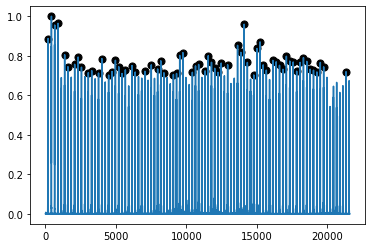

In [7]:
plt.plot(data)
plt.scatter(x=ind, y=data[ind], c="black", s=50, zorder=2)
print('%Missing Peaks: ', (1-len(ind)/(len(ind)+21))*100)


## 2. Resting ECG

## Method 1
## Algorithm implemented : Pan Tompkins Algorithm (using a Band Pass Filter)

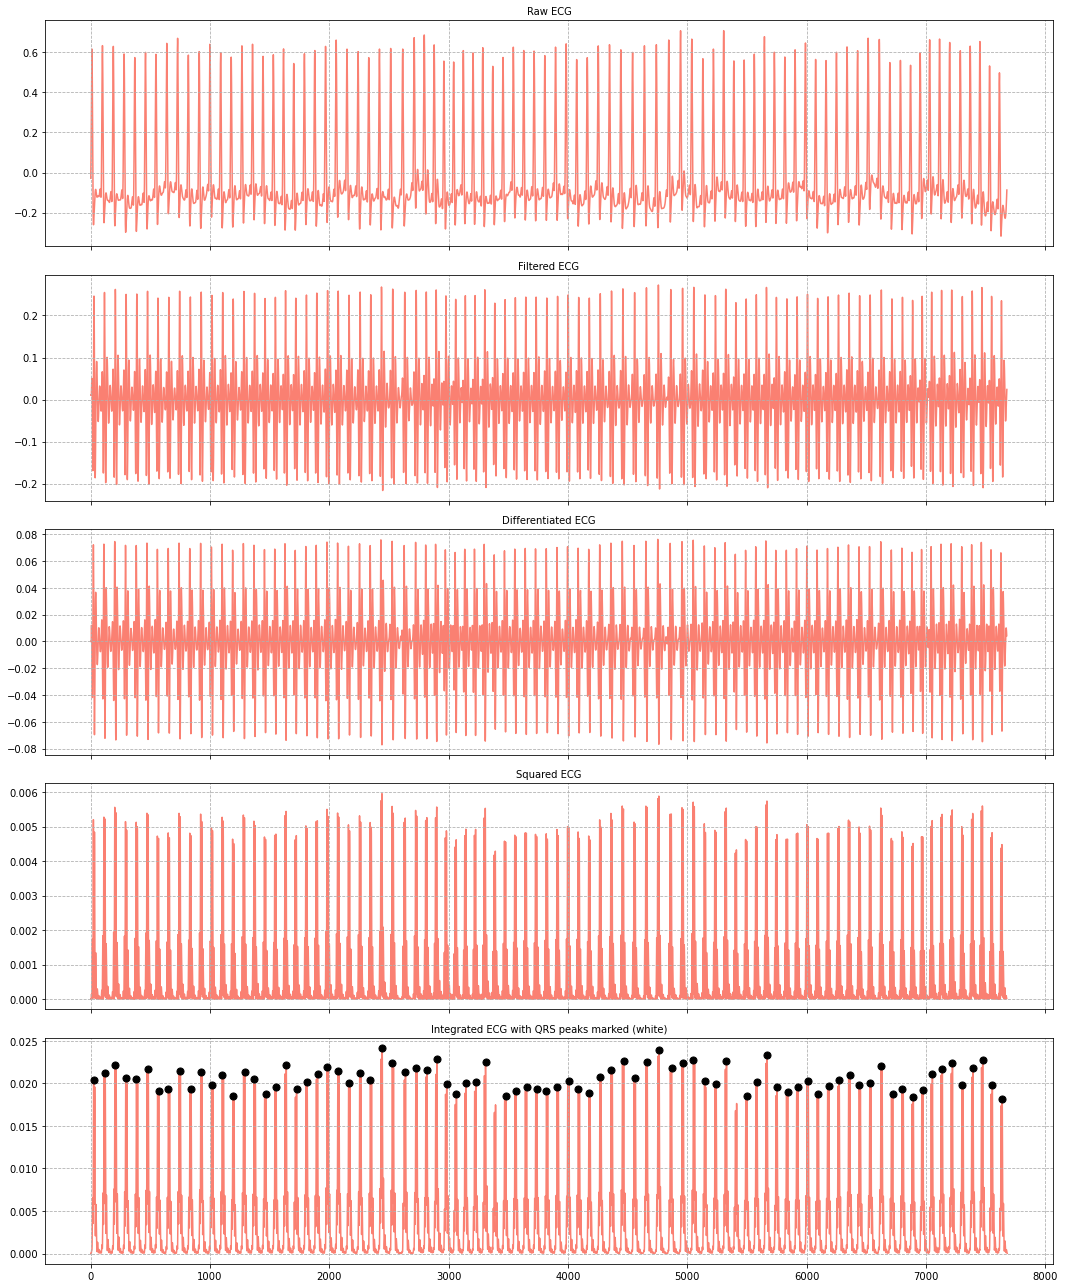

qrs peaks indices
[  24  121  203  293  383  482  570  651  751  841  923 1013 1103 1191
 1290 1370 1467 1554 1639 1725 1814 1901 1982 2071 2162 2255 2344 2443
 2528 2638 2725 2819 2902 2984 3065 3146 3228 3309 3479 3565 3653 3740
 3820 3910 4008 4087 4176 4268 4362 4467 4565 4664 4764 4868 4967 5052
 5145 5243 5329 5500 5585 5670 5754 5842 5927 6014 6099 6187 6274 6363
 6442 6530 6624 6722 6801 6895 6976 7055 7138 7223 7303 7395 7477 7558
 7640]
noise peaks indices
[]
Detected Heart Rate:  85
%Missing peaks:  2.298850574712641


In [20]:
from matplotlib import pyplot as plt
from scipy import signal
from matplotlib import style
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter, firwin, convolve


ecg1 = pd.read_csv('MITBIHNormalSinusRhythmDatabase.csv')
ecg1 = ecg1.drop([0],axis =0)
ecg1.columns = ['Idx', 'ECG']
ecg1['ECG'] = pd.to_numeric(ecg1['ECG'])
ecg1 = ecg1.drop(['Idx'], axis = 1)

combo_sig = list(ecg1['ECG'][:])
fs = 128
numtaps = 31
lpf_cutoff = 5
plt.figure(1)
plt.plot(ecg1['ECG'][0:640])
#lowpass
lowpass_coeff = firwin(numtaps, lpf_cutoff, nyq = fs/2)
lpf_output = convolve(combo_sig,lowpass_coeff, mode = 'same')
plt.figure(2)
plt.plot(lpf_output[0:640])


fl = 5
fh = 11.0
fo = 3

int_win = 5  

peak_limit = 0.018
peak_spacing = 15 

refractory_duration = 64 

filt_ecg = None
diff_ecg= None
squared_ecg = None
int_ecg = None
detected_peaks_indices = None
detected_peaks_values = None


# Detection results.
qrs_peaks_indices = np.array([], dtype=int)
noise_peaks_indices = np.array([], dtype=int)

def detect_peaks(lpf_output,peak_limit,peak_spacing):

    # Measurements filtering - 0-15 Hz band pass filter.
    filt_ecg = bpf(lpf_output, fl, fh, fs, fo)
    filt_ecg[:5] = filt_ecg[5]

    # Derivative
    diff_ecg = np.ediff1d(filt_ecg)

    # Squaring
    squared_ecg = diff_ecg ** 2
    # Moving-window integration.
    int_ecg = np.convolve(squared_ecg, np.ones(int_win))

    # peak detection on integrated measurements.
    peaks_indices = findpeaks(int_ecg, peak_spacing, peak_limit)

    peaks_values = int_ecg[peaks_indices]
    return filt_ecg, diff_ecg, squared_ecg, int_ecg, peaks_indices, peaks_values

def detect_qrs(lpf_output,peaks_indices,peaks_values,qrs_peaks_indices,noise_peaks_indices):
    qrs_peak_value = 0.0
    noise_peak_value = 0.0
    threshold_value = 0.0
        
    for detected_peak_index, detected_peaks_value in zip(peaks_indices, peaks_values):
        last_qrs_index = 0

        if detected_peak_index - last_qrs_index > refractory_duration or not qrs_peaks_indices.size:
            if detected_peaks_value > threshold_value:
                qrs_peaks_indices = np.append(qrs_peaks_indices, detected_peak_index)
                qrs_peak_value = 0.125 * detected_peaks_value + (1 - 0.125)*qrs_peak_value
            else:
                noise_peaks_indices = np.append(noise_peaks_indices, detected_peak_index)
                noise_peak_value = 0.125 * detected_peaks_value + (1 - 0.125) * noise_peak_value

            threshold_value = noise_peak_value + 0.25 * (qrs_peak_value - noise_peak_value)
    return qrs_peaks_indices, noise_peaks_indices


def plot_detection_data(lpf_output, filt_ecg, diff_ecg, squared_ecg, int_ecg, qrs_peaks_indices):
    def plot_data(axis, data, title='' ):
        axis.set_title(title, fontsize=10)
        axis.grid(which='both', axis='both', linestyle='--')
        axis.plot(data, color="salmon", zorder=1)

    def plot_points(axis, values, indices):
        axis.scatter(x=indices, y=values[indices], c="black", s=50, zorder=2)

    plt.close('all')
    fig, axarr = plt.subplots(5, sharex=True, figsize=(15, 18))

    plot_data(axarr[0], lpf_output, title='Raw ECG')
    plot_data(axarr[1], filt_ecg, title='Filtered ECG')
    plot_data(axarr[2], diff_ecg, title='Differentiated ECG')
    plot_data(axarr[3], squared_ecg, title='Squared ECG')
    plot_data(axarr[4], int_ecg, title='Integrated ECG with QRS peaks marked (white)')
    plot_points(axarr[4], int_ecg, qrs_peaks_indices)
    plt.tight_layout()
    plt.show()
    plt.close()

def bpf( data, fl, fh, fs, fo):
    nyq_freq = 0.5 * fs
    low = fl / nyq_freq
    high = fh / nyq_freq
    b, a = butter(fo, [low, high], btype="band")
    y = lfilter(b, a, data)
    return y

def findpeaks(data, spacing, limit):
    len = data.size
    spacing = int(spacing)
    x = np.zeros(int(len + 2 * spacing))
    x[:spacing] = data[0] - 1.e-6
    x[-spacing:] = data[-1] - 1.e-6
    x[spacing:spacing + len] = data
    peak_ = np.zeros(len)
    peak_[:] = True
    for s in range(spacing):
        start = spacing - s - 1
        h_b = x[start: start + len]  
        start = spacing
        h_c = x[start: start + len]  
        start = spacing + s + 1
        h_a = x[start: start + len]  
        peak_ = np.logical_and(peak_, np.logical_and(h_c > h_b, h_c > h_a))

    ind = np.argwhere(peak_)
    ind = ind.reshape(ind.size)
    if limit is not None:
        ind = ind[data[ind] > limit]
    return ind


lpf_output = lpf_output[0:]
filt_ecg, diff_ecg, squared_ecg, int_ecg, peaks_indices, peaks_values = detect_peaks(lpf_output,peak_limit,peak_spacing)
qrs_peaks_indices, noise_peaks_indices = detect_qrs(lpf_output,peaks_indices,peaks_values,qrs_peaks_indices,noise_peaks_indices)
plot_detection_data(lpf_output, filt_ecg, diff_ecg, squared_ecg, int_ecg,qrs_peaks_indices)

print("qrs peaks indices")
print(qrs_peaks_indices)
print("noise peaks indices")
print(noise_peaks_indices)
l = qrs_peaks_indices.size
print("%Missing peaks: ", (1-l/(l+2))*100)



## Method 2
## Pan Tompkins Algorithm using the actual transfer function equations from the original paper and using the same peak detection algorithm as above


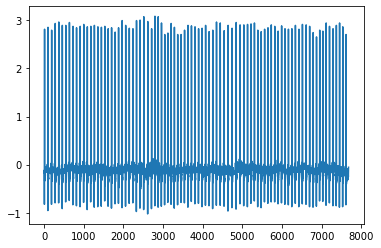

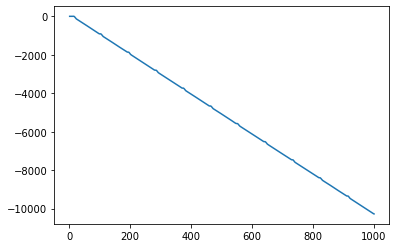

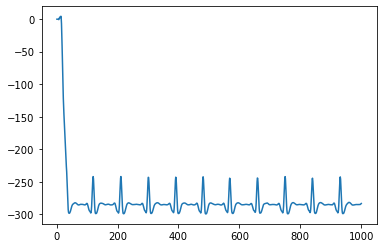

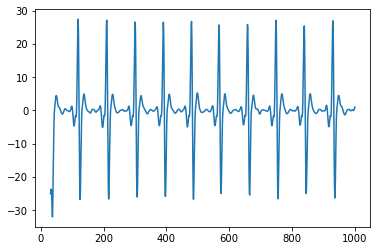

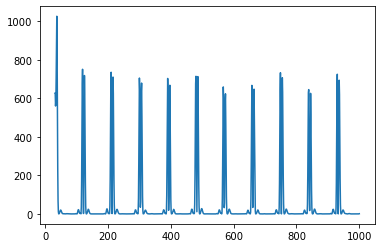

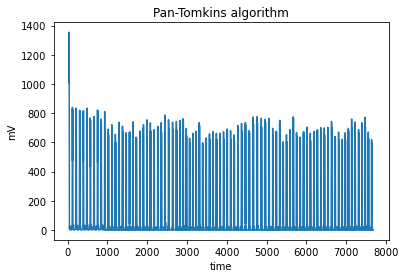

Detected Heart rate:  78
%Missing Peaks:  10.344827586206895


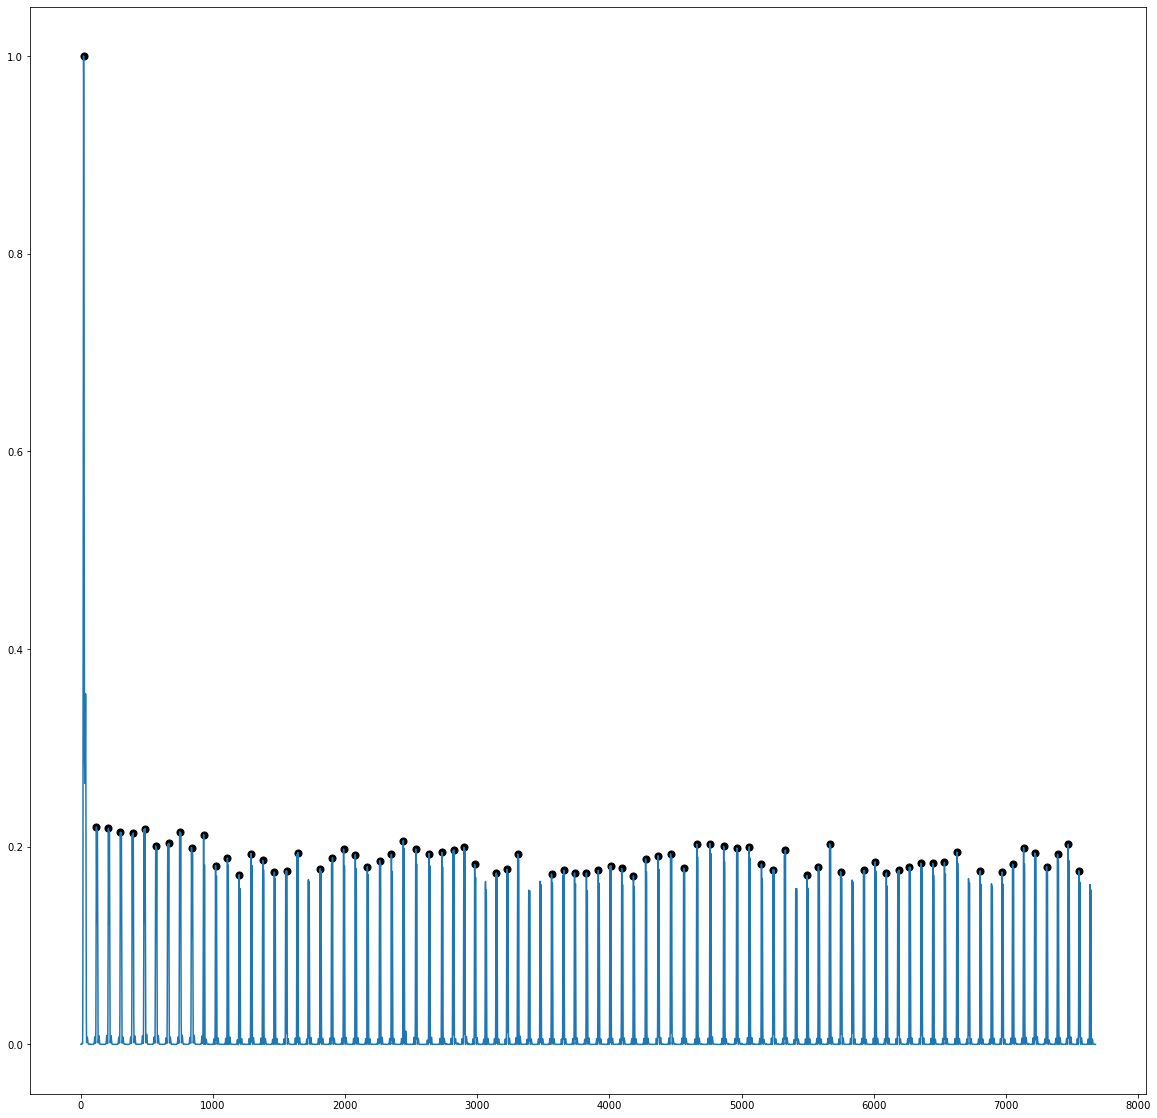

In [21]:

#low-pass filter
def lpf(x):
    y = x.copy()
    for n in range(len(x)):
        if(n < 12):
            continue
        y.iloc[n,1] = 2*y.iloc[n-1,1] - y.iloc[n-2,1] + x.iloc[n,1] - 2*x.iloc[n-6,1] + x.iloc[n-12,1] 
    return y


#high-pass filter
def hpf(x):
    y = x.copy()	
    for n in range(len(x)):        
        if(n < 32):
            continue
        y.iloc[n,1] = y.iloc[n-1,1] - x.iloc[n,1]/32 + x.iloc[n-16,1] - x.iloc[n-17,1] + x.iloc[n-32,1]/32
    return y

#defivative of signal
def deriv(x):
    y = x.copy()
    for n in range(len(x)):
        if(n < 4):
            continue
        y.iloc[n, 1] = (2*x.iloc[n,1] + x.iloc[n-1,1] - x.iloc[n-3,1] - 2*x.iloc[n-4,1])/4
    return y

#squarring the signal
def squaring(x):
    y = x.copy()
    for n in range(len(x)):
        y.iloc[n,1] = x.iloc[n,1]**2
    return y

#integral of the signal for a moving window of ws size.
def win_sum(x, ws):
    y = x.copy()
    l = int(ws/2)	
    for n in range(len(x)):
        tmp_sum = 0
        if(n > 933-l):
            break

        if(n < l):
            continue
        for j in range(n-l,n+l+1):
            tmp_sum += x.iloc[j,1]
        y.iloc[n,1] = tmp_sum/(l+1)		
    return y

ecg1 = pd.read_csv('MITBIHNormalSinusRhythmDatabase.csv')
ecg1 = ecg1.drop([0],axis =0)
ecg1.columns = ['Idx', 'ECG']
ecg1['ECG'] = pd.to_numeric(ecg1['ECG'])
plt.figure(1)
plt.plot( ecg1.iloc[:,1])

lpf_output = lpf(ecg1)
plt.figure(2)
plt.plot( lpf_output.iloc[:1000,1])

hpf_output = hpf(lpf_output)
plt.figure(3)
plt.plot( hpf_output.iloc[:1000,1])

derivative_output = deriv(hpf_output)
plt.figure(4)
plt.plot(derivative_output.iloc[30:1000,1])

squared_output = squaring(derivative_output)
plt.figure(5)
plt.plot(squared_output.iloc[30:1000,1])

window_size = 5 
summing_window_output = win_sum(squared_output, window_size)

plt.figure(6)
plt.plot(summing_window_output.iloc[30:,1])
plt.title('Pan-Tomkins algorithm')
plt.xlabel('time')
plt.ylabel('mV')
plt.show()


data = list(summing_window_output['ECG'])/np.max(list(summing_window_output['ECG']))
def findpeaks(data, spacing, limit):
    len = data.size
    spacing = int(spacing)
    x = np.zeros(int(len + 2 * spacing))
    x[:spacing] = data[0] - 1.e-6
    x[-spacing:] = data[-1] - 1.e-6
    x[spacing:spacing + len] = data
    peak_ = np.zeros(len)
    peak_[:] = True
    for s in range(spacing):
        start = spacing - s - 1
        h_b = x[start: start + len]  
        start = spacing
        h_c = x[start: start + len]  
        start = spacing + s + 1
        h_a = x[start: start + len]  
        peak_ = np.logical_and(peak_, np.logical_and(h_c > h_b, h_c > h_a))

    ind = np.argwhere(peak_)
    ind = ind.reshape(ind.size)
    if limit is not None:
        ind = ind[data[ind] > limit]
    return ind
ind = findpeaks(data,15,0.17)
plt.figure(figsize= (20,20))
plt.plot(data)
plt.scatter(x=ind, y=data[ind], c="black", s=50, zorder=2)
print('%Missing Peaks: ', (1-len(ind)/(len(ind)+9))*100)



## As we can observe the algorithm using a pre implemented filter pereforms better than the transfer function provided in the paper
### This can be because of my assumption in the process which can be further studied and improved upon. There can be a lot of improvement done upon this.
### A few suggestions to improve my own code from my understanding are:
    1. Pre processing of signals using Notch filter to remove the noise from power line
    2. Automation of the find peak algorithm in some manner to automatically read the lowewr cut off for peak detection
